## Imports

In [1]:
import pandas as pd
import numpy as np
import pickle


from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin 
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report

from transformers import AutoTokenizer,AutoModelForSequenceClassification
from transformers import TextClassificationPipeline
from transformers import Trainer

from datasets import Dataset,DatasetDict

from tfidf import TfidfPipepline
from tfidf import CountVectorizerPipepline

/home/janst/.local/share/virtualenvs/sentimental-review-RqoP1T91/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-09-05 17:31:41.392060: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-05 17:31:41.392076: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-05 17:31:46.122524: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-05 17:31:46.122560: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jan-la

## IMDb data

In [2]:
data_path = "../data/imdb_shuffle.csv"

df = pd.read_csv(data_path)
df=df[-500:]

In [3]:
df.reset_index(drop=True)

,Review,Rating,Sentiment,Label
0,Possibly the best John Travolta role ever. Sat...,8,1,2
1,Are you familiar with concept of children's ar...,3,0,1
2,This is one of the best movies I've seen. The ...,9,1,3
3,When I saw this film the first time I was very...,10,1,3
4,Where to start... If this movie had been a dar...,3,0,1
...,...,...,...,...
495,William Petersen (that C.S.I guy) has a small ...,4,0,1
496,The back cover of the DVD (missed this one whe...,3,0,1
497,Fred Carpenter screened Eddie Monroe at Boston...,10,1,3
498,I saw this on television more years ago than I...,10,1,3


In [4]:
X_pred=list(df["Review"])
y_true = list(df["Sentiment"])
y4_true = list(df["Label"])

In [5]:
# Transform pandas dataset to hugging face dataset
ds = DatasetDict()
df_test=pd.DataFrame({"text":X_pred,"label":y_true})
test = Dataset.from_pandas(df_test)

ds["test"] = test
ds

DatasetDict({
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 500
    })
})

In [6]:
ds4 = DatasetDict()
df4_test=pd.DataFrame({"text":X_pred,"label":y4_true})
test4 = Dataset.from_pandas(df4_test)

ds4["test"] = test4
ds4

DatasetDict({
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 500
    })
})

## Get bert / distilbert Tokenizer

In [7]:
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

## Tokenize IMDb dataset review

In [8]:
def bert_tokenize_function(examples):
    return bert_tokenizer(examples["text"],padding="max_length", truncation=True)

def distilbert_tokenize_function(examples):
    return distilbert_tokenizer(examples["text"],padding="max_length", truncation=True)

In [9]:
bert_tokenized_datasets=ds.map(bert_tokenize_function,batched=True)
distilbert_tokenized_datasets=ds.map(distilbert_tokenize_function,batched=True)

100%|██████████| 1/1 [00:00<00:00, 10.82ba/s]


## Load model

In [10]:
bert_model = AutoModelForSequenceClassification.from_pretrained("../model/bert/")
distilbert_model = AutoModelForSequenceClassification.from_pretrained("../model/distilbert/")
bert4_model = AutoModelForSequenceClassification.from_pretrained("../model/bert4/")
distilbert4_model = AutoModelForSequenceClassification.from_pretrained("../model/distilbert4/")

In [11]:
target_names=["Negativ", "Positiv"]

## Bert (cased) predict label {"Negativ" : 0,"Positiv" : 1}

In [12]:
bert_trainer = Trainer(model=bert_model)
y_pred_bert=bert_trainer.predict(bert_tokenized_datasets["test"])

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 500
  Batch size = 8
100%|██████████| 63/63 [03:19<00:00,  3.16s/it]


In [13]:
preds_bert = np.argmax(y_pred_bert.predictions, axis=-1)

In [14]:
print(classification_report(y_pred=preds_bert,y_true=y_true,target_names=target_names))

              precision    recall  f1-score   support

     Negativ       0.92      0.93      0.92       268
     Positiv       0.91      0.91      0.91       232

    accuracy                           0.92       500
   macro avg       0.92      0.92      0.92       500
weighted avg       0.92      0.92      0.92       500



In [15]:
cm = confusion_matrix(y_pred=preds_bert,y_true=y_true)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)

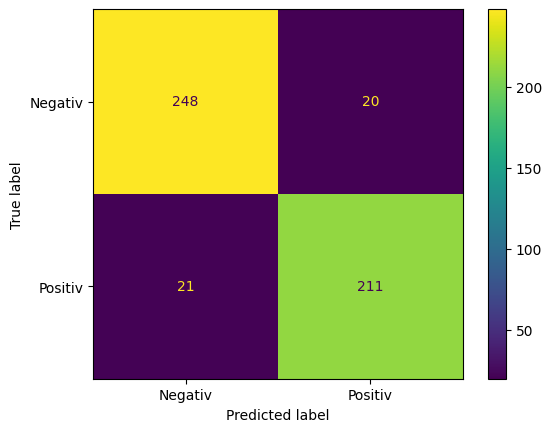

In [16]:
disp.plot()

## DistilBert (uncased) predict label {"Negativ" : 0,"Positiv" : 1}

In [17]:
distilbert_trainer=Trainer(model=distilbert_model)
y_pred_distilbert=distilbert_trainer.predict(distilbert_tokenized_datasets["test"])

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 500
  Batch size = 8
100%|██████████| 63/63 [01:39<00:00,  1.58s/it]


In [18]:
preds_distilbert = np.argmax(y_pred_distilbert.predictions, axis=-1)

In [19]:
print(classification_report(y_pred=preds_distilbert,y_true=y_true,target_names=target_names))

              precision    recall  f1-score   support

     Negativ       0.92      0.93      0.92       268
     Positiv       0.91      0.91      0.91       232

    accuracy                           0.92       500
   macro avg       0.92      0.92      0.92       500
weighted avg       0.92      0.92      0.92       500



In [20]:
cm = confusion_matrix(y_pred=preds_distilbert,y_true=y_true)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)

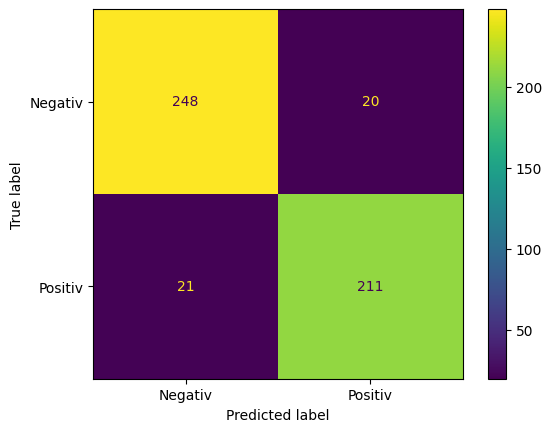

In [21]:
disp.plot()

## Bert (cased) predict label {"Very negativ" : 0, "Negativ" : 1, "Positiv" : 2, "Very positiv" : 3}

In [22]:
bert4_trainer=Trainer(model=bert4_model)
y_pred_bert4=bert4_trainer.predict(bert_tokenized_datasets["test"])

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 500
  Batch size = 8
100%|██████████| 63/63 [03:22<00:00,  3.21s/it]


In [23]:
preds_bert4 = np.argmax(y_pred_bert4.predictions, axis=-1)

In [24]:
print(classification_report(y_pred=preds_bert4,y_true=y4_true))

              precision    recall  f1-score   support

           0       0.79      0.74      0.76       156
           1       0.60      0.68      0.64       112
           2       0.58      0.65      0.61        92
           3       0.81      0.72      0.77       140

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.69       500
weighted avg       0.72      0.70      0.71       500



In [25]:
cm = confusion_matrix(y_pred=preds_bert4,y_true=y4_true)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

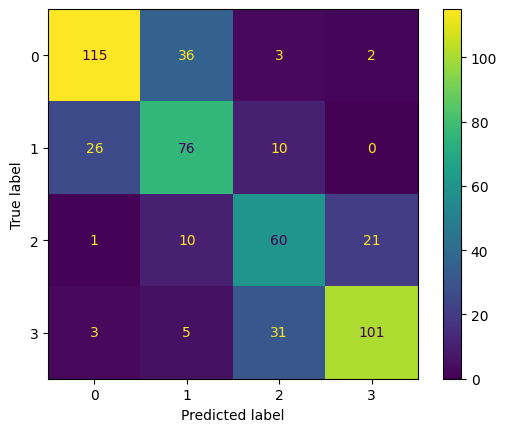

In [26]:
disp.plot()

## DistilBert (uncased) predict label {"Very negativ" : 0, "Negativ" : 1, "Positiv" : 2, "Very positiv" : 3}

In [27]:
distilbert4_trainer=Trainer(model=distilbert4_model)
y_pred_distilbert4=distilbert4_trainer.predict(distilbert_tokenized_datasets["test"])

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 500
  Batch size = 8
100%|██████████| 63/63 [01:42<00:00,  1.63s/it]


In [28]:
preds_distilbert4 = np.argmax(y_pred_distilbert4.predictions, axis=-1)


In [29]:
print(classification_report(y_pred=preds_distilbert4,y_true=y4_true))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78       156
           1       0.63      0.68      0.65       112
           2       0.54      0.58      0.55        92
           3       0.74      0.73      0.74       140

    accuracy                           0.70       500
   macro avg       0.68      0.68      0.68       500
weighted avg       0.70      0.70      0.70       500



In [30]:
cm = confusion_matrix(y_pred=preds_distilbert4,y_true=y4_true)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

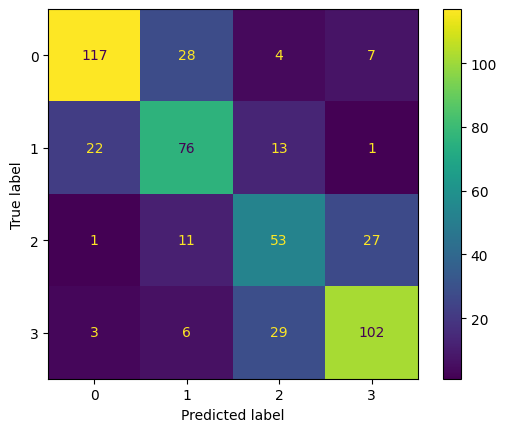

In [31]:
disp.plot()

## TFIDF predict label {"Negativ" : 0, "Positiv" : 1}

In [32]:
tfidf_pipeline = TfidfPipepline(pkl_name="../model/tfidf/tfidf.pkl")

In [33]:
preds_tfidf =tfidf_pipeline._train_model.predict(X_pred)

In [34]:
print(classification_report(y_pred=preds_tfidf,y_true=y_true,target_names=target_names))

              precision    recall  f1-score   support

     Negativ       0.91      0.85      0.88       268
     Positiv       0.84      0.91      0.87       232

    accuracy                           0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.88      0.88      0.88       500



In [35]:
cm = confusion_matrix(y_pred=preds_tfidf,y_true=y_true)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)

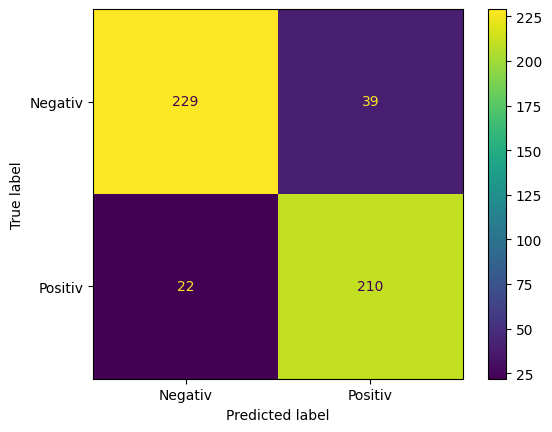

In [36]:
disp.plot()

## Count vectorizer predict label {"Negativ" : 0, "Positiv" : 1}

In [37]:
count_vectorizer_pipeline = CountVectorizerPipepline(pkl_name="../model/countvectorizer/countvectorizer.pkl")

In [38]:
preds_count_vectorizer =count_vectorizer_pipeline._train_model.predict(X_pred)

In [39]:
print(classification_report(y_pred=preds_count_vectorizer,y_true=y_true,target_names=target_names))

              precision    recall  f1-score   support

     Negativ       0.88      0.85      0.87       268
     Positiv       0.83      0.87      0.85       232

    accuracy                           0.86       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.86      0.86      0.86       500



In [40]:
cm = confusion_matrix(y_pred=preds_count_vectorizer,y_true=y_true)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)

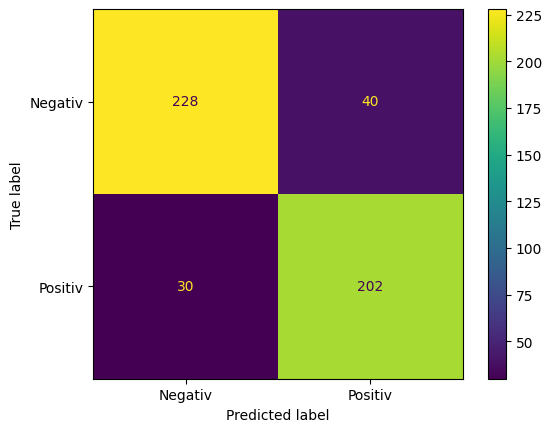

In [41]:
disp.plot()

## Twitter data

In [42]:
twitter_data_path = "../data/twitter_test_db.csv"

df_twitter = pd.read_csv(twitter_data_path,sep=";")


In [43]:
X_pred_twitter = list(df_twitter["tweet"])
y_true_twitter = list(df_twitter["sentiment"])

In [44]:
ds_twitter = DatasetDict()
df_test_twitter = pd.DataFrame({"text":X_pred_twitter,"label":y_true_twitter})
test_twitter = Dataset.from_pandas(df_test_twitter)

ds_twitter["test"]=test_twitter
ds_twitter

DatasetDict({
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 143
    })
})

## Tokenize twitter dataset tweets

In [45]:
bert_twitter_tokenized_datasets = ds_twitter.map(bert_tokenize_function,batched=True)
distilbert_twitter_tokenized_datasets = ds_twitter.map(distilbert_tokenize_function,batched=True)

100%|██████████| 1/1 [00:00<00:00, 62.41ba/s]


## Bert (cased) predict label {"Negativ" : 0,"Positiv" : 1}

In [46]:
y_pred_twitter_bert = bert_trainer.predict(bert_twitter_tokenized_datasets["test"])

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 143
  Batch size = 8
100%|██████████| 18/18 [00:56<00:00,  3.15s/it]


In [47]:
preds_twitter_bert=np.argmax(y_pred_twitter_bert.predictions,axis=-1)

In [48]:
print(classification_report(y_pred=preds_twitter_bert,y_true=y_true_twitter,target_names=target_names))

              precision    recall  f1-score   support

     Negativ       0.39      0.83      0.53        46
     Positiv       0.83      0.39      0.53        97

    accuracy                           0.53       143
   macro avg       0.61      0.61      0.53       143
weighted avg       0.69      0.53      0.53       143



In [49]:
cm = confusion_matrix(y_pred=preds_twitter_bert,y_true=y_true_twitter)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)

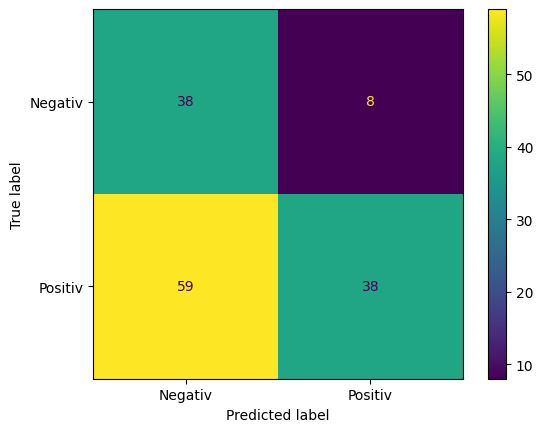

In [50]:
disp.plot()

## DistilBert (uncased) predict label {"Negativ" : 0,"Positiv" : 1}

In [51]:
y_pred_twitter_distilbert = distilbert_trainer.predict(distilbert_twitter_tokenized_datasets["test"])

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 143
  Batch size = 8
100%|██████████| 18/18 [00:30<00:00,  1.70s/it]


In [52]:
preds_twitter_distilbert=np.argmax(y_pred_twitter_distilbert.predictions,axis=-1)

In [53]:
print(classification_report(y_pred=preds_twitter_distilbert,y_true=y_true_twitter,target_names=target_names))

              precision    recall  f1-score   support

     Negativ       0.47      0.74      0.58        46
     Positiv       0.83      0.61      0.70        97

    accuracy                           0.65       143
   macro avg       0.65      0.67      0.64       143
weighted avg       0.72      0.65      0.66       143



In [54]:
cm = confusion_matrix(y_pred=preds_twitter_distilbert,y_true=y_true_twitter)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)

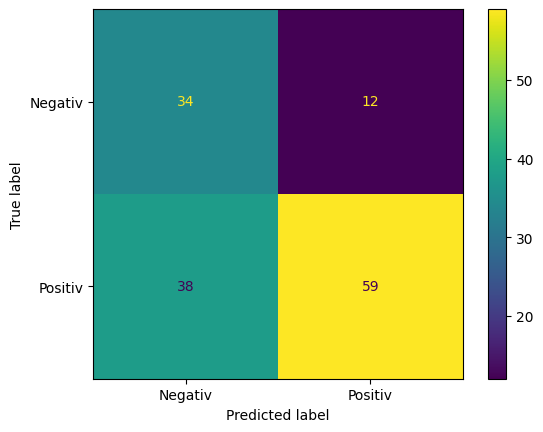

In [55]:
disp.plot()

## TFIDF predict label {"Negativ" : 0,"Positiv" : 1}

In [56]:
preds_twitter_tfidf =tfidf_pipeline._train_model.predict(X_pred_twitter)

In [57]:
print(classification_report(y_pred=preds_twitter_tfidf,y_true=y_true_twitter,target_names=target_names))

              precision    recall  f1-score   support

     Negativ       0.43      0.54      0.48        46
     Positiv       0.75      0.66      0.70        97

    accuracy                           0.62       143
   macro avg       0.59      0.60      0.59       143
weighted avg       0.65      0.62      0.63       143



In [58]:
cm = confusion_matrix(y_pred=preds_twitter_tfidf,y_true=y_true_twitter)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)

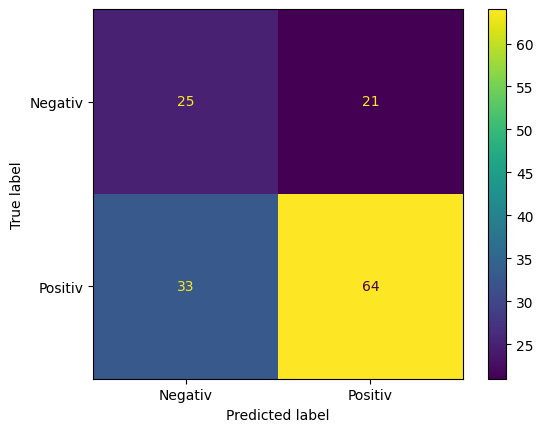

In [59]:
disp.plot()

## Count vectorizer predict label {"Negativ" : 0,"Positiv" : 1}

In [60]:
preds_twitter_count_vectorizer =count_vectorizer_pipeline._train_model.predict(X_pred_twitter)

In [61]:
print(classification_report(y_pred=preds_twitter_count_vectorizer,y_true=y_true_twitter,target_names=target_names))

              precision    recall  f1-score   support

     Negativ       0.43      0.52      0.47        46
     Positiv       0.75      0.67      0.71        97

    accuracy                           0.62       143
   macro avg       0.59      0.60      0.59       143
weighted avg       0.64      0.62      0.63       143



In [62]:
cm = confusion_matrix(y_pred=preds_twitter_count_vectorizer,y_true=y_true_twitter)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)

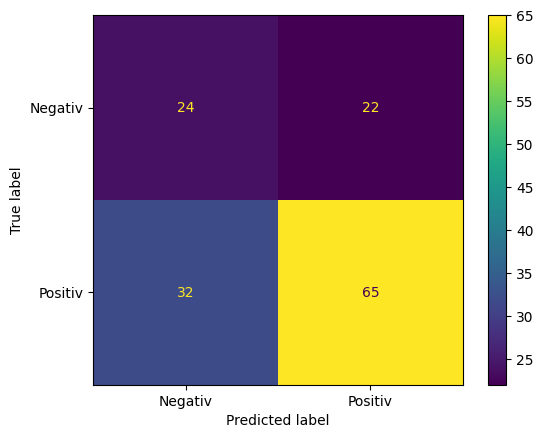

In [63]:
disp.plot()